# Fitting transit times

In [57]:
import exoplanet

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.2'


Fitting for or marginalizing over the transit times or transit timing variations (TTVs) can be useful for several reasons, and it is a compelling use case for *exoplanet* becuase the number of parameters in the model increases significantly because there will be a new parameter for each transit.
The performance of the NUTS sampler used by *exoplanet* scales well with the number of parameters, so a TTV model should be substantially faster to run to convergence with *exoplanet* than with other tools.
There are a few definitions and subtleties that should be considered before jumping in.

In this tutorial, we will be using a "descriptive" model [orbits.TTVOrbit](https://docs.exoplanet.codes/en/stable/user/api/#exoplanet.orbits.TTVOrbit) to fit the light curve where the underlying motion is still Keplerian, but the time coordinate is warped to make `t0` a function of time.
All of the other orbital elements besides `t0` are shared across all orbits, but the `t0` for each transit will be a parameter.
This means that other variations (like transit duration variations) are not currently supported, but it would be possible to include more general effects.
`exoplanet` also supports photodynamics modeling using the [orbits.ReboundOrbit](https://docs.exoplanet.codes/en/stable/user/api/#exoplanet.orbits.ReboundOrbit) for more detailed analysis, but that is a topic for a future tutorial.

It is also important to note that "transit time" within *exoplanet* (and most other transit fitting software) is defined as the time of conjunction (called `t0` in the code): the time when the true anomaly is $\pi/2 - \omega$.
Section 18 of [the EXOFASTv2 paper](https://arxiv.org/abs/1907.09480) includes an excellent discussion of some of the commonly used definitions of "transit time" in the literature.

Finally, there is a subtlety in the definition of the "period" of an orbit with TTVs.
Two possible definitions are: (1) the average time between transits, or (2) the slope of a least squares fit to the transit times as a function of transit number.
In *exoplanet*, we use the latter definition and call this parameter the `ttv_period` to distinguish it from the `period` of the underlying Keplerian motion which sets the shape and duration of the transit.
By default, these two periods are constrained to be equal, but it can be useful to fit for both parameters since the shape of the transit might not be perfectly described by the same period.
That being said, if you fit for both periods, make sure that you constrain `ttv_period` and `period` to be similar or things can get a bit ugly.

To get started, let's generate some simulated transit times.
We'll use the [orbits.ttv.compute_expected_transit_times](https://docs.exoplanet.codes/en/stable/user/api/#exoplanet.orbits.ttv.compute_expected_transit_times) function to get the expected transit times for a linear ephemeris within some observation baseline:

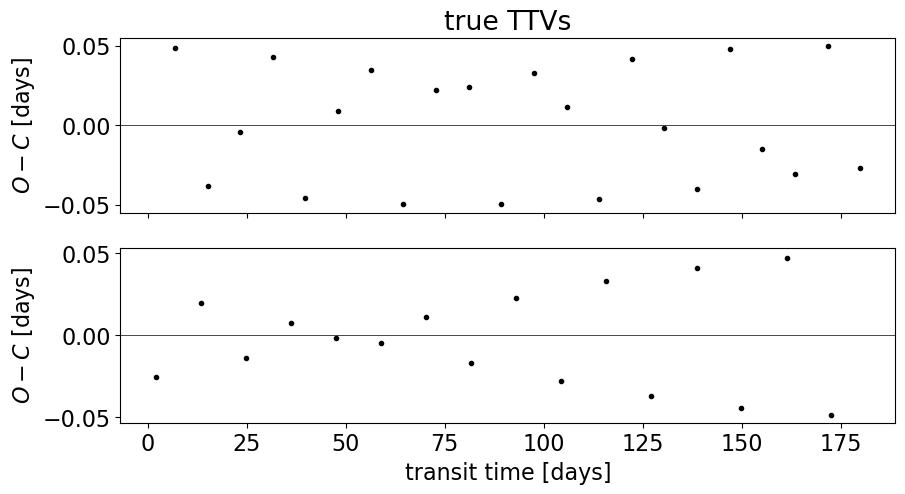

In [58]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

np.random.seed(3948)
true_periods = np.random.uniform(8, 12, 2)
true_t0s = true_periods * np.random.rand(2)
t = np.arange(0, 180, 0.01)
texp = 0.01
yerr = 5e-4

# Compute the transit times for a linear ephemeris
true_transit_times = xo.orbits.ttv.compute_expected_transit_times(
    t.min(), t.max(), true_periods, true_t0s
)

# Simulate transit timing variations using a simple model
true_ttvs = [
    (0.05 - (i % 2) * 0.1) * np.sin(2 * np.pi * tt / 23.7)
    for i, tt in enumerate(true_transit_times)
]
true_transit_times = [tt + v for tt, v in zip(true_transit_times, true_ttvs)]

# Plot the true TTV model
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax1.plot(true_transit_times[0], true_ttvs[0], ".k")
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))
ax1.set_ylabel("$O-C$ [days]")

ax2.plot(true_transit_times[1], true_ttvs[1], ".k")
ax2.axhline(0, color="k", lw=0.5)
ax2.set_ylim(np.max(np.abs(ax2.get_ylim())) * np.array([-1, 1]))
ax2.set_ylabel("$O-C$ [days]")

ax2.set_xlabel("transit time [days]")
_ = ax1.set_title("true TTVs")




Now, like in the [Transit fitting](https://docs.exoplanet.codes/en/stable/tutorials/transit/) tutorial, we'll set up the the model using *PyMC3* and *exoplanet*, and then simulate a data set from that model.

In [59]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt

np.random.seed(9485023)

with pm.Model() as model:

    # This part of the model is similar to the model in the `transit` tutorial
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    u = xo.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    logr = pm.Uniform(
        "logr",
        lower=np.log(0.01),
        upper=np.log(0.1),
        shape=2,
        testval=np.log([0.04, 0.06]),
    )
    r = pm.Deterministic("r", tt.exp(logr))
    b = xo.ImpactParameter(
        "b", ror=r, shape=2, testval=0.5 * np.random.rand(2)
    )

    # Now we have a parameter for each transit time for each planet:
    transit_times = []
    for i in range(2):
        transit_times.append(
            pm.Normal(
                "tts_{0}".format(i),
                mu=true_transit_times[i],
                sd=1.0,
                shape=len(true_transit_times[i]),
            )
        )

    # Set up an orbit for the planets
    orbit = xo.orbits.TTVOrbit(b=b, transit_times=transit_times)

    # It will be useful later to track some parameters of the orbit
    pm.Deterministic("t0", orbit.t0)
    pm.Deterministic("period", orbit.period)
    for i in range(2):
        pm.Deterministic("ttvs_{0}".format(i), orbit.ttvs[i])

    # The rest of this block follows the transit fitting tutorial
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t, texp=texp
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    pm.Deterministic("light_curves", light_curves)

    # ******************************************************************* #
    # On the folowing lines, we simulate the dataset that we will fit     #
    #                                                                     #
    # NOTE: if you are fitting real data, you shouldn't include this line #
    #       because you already have data!                                #
    # ******************************************************************* #
    y = pmx.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    # ******************************************************************* #
    # End of fake data creation; you want to include the following lines  #
    # ******************************************************************* #

    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    map_soln = model.test_point
    map_soln = pmx.optimize(start=map_soln, vars=transit_times)
    map_soln = pmx.optimize(start=map_soln, vars=[r, b])
    map_soln = pmx.optimize(start=map_soln, vars=transit_times)
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [tts_1, tts_0]


message: Desired error not necessarily achieved due to precision loss.
logp: 111249.68172440518 -> 111266.17819225049
optimizing logp for variables: [b, logr]


message: Desired error not necessarily achieved due to precision loss.
logp: 111266.17819225049 -> 111266.7130073685
optimizing logp for variables: [tts_1, tts_0]


message: Desired error not necessarily achieved due to precision loss.
logp: 111266.7130073685 -> 111266.77019774639
optimizing logp for variables: [tts_1, tts_0, b, logr, u, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 111266.77019774639 -> 111266.84437449422


In [60]:
print(map_soln)

{'mean': array(5.72446304e-07), 'u_quadlimbdark__': array([-1.29416723, -0.55117146]), 'logr_interval__': array([0.41780095, 1.26049807]), 'b_impact__': array([-0.40891288, -0.74126213]), 'tts_0': array([  6.96045664,  15.10993795,  23.38079767,  31.66841322,
        39.81316043,  48.10637202,  56.37042669,  64.52524862,
        72.83476203,  81.06866969,  89.24000915,  97.55962263,
       105.77102142, 113.94931785, 122.27267494, 130.47471211,
       138.66775142, 146.99232707, 155.1649234 , 163.38841225,
       171.70962832, 179.86563693]), 'tts_1': array([  1.9703547 ,  13.39500495,  24.74384273,  36.14353554,
        47.5119962 ,  58.88879687,  70.2842241 ,  81.63397683,
        93.05416661, 104.38457076, 115.82449387, 127.13254321,
       138.59031605, 149.88611088, 161.35277385, 172.63720733]), 'u': array([0.3391536 , 0.12468722]), 'logr': array([-3.21681058, -2.81119889]), 'r': array([0.0400827 , 0.06013286]), 'b': array([0.41517274, 0.34213478]), 't0': array([6.91621633, 1.9964

Here's our simulated light curve and the initial model:

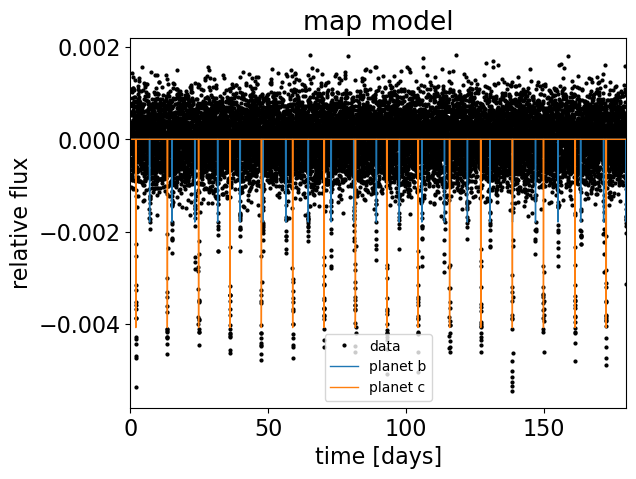

In [61]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

This looks similar to the light curve from the [Transit fitting](https://docs.exoplanet.codes/en/stable/tutorials/transit/) tutorial, but if we try plotting the folded transits, we can see that something isn't right: these transits look pretty smeared out!

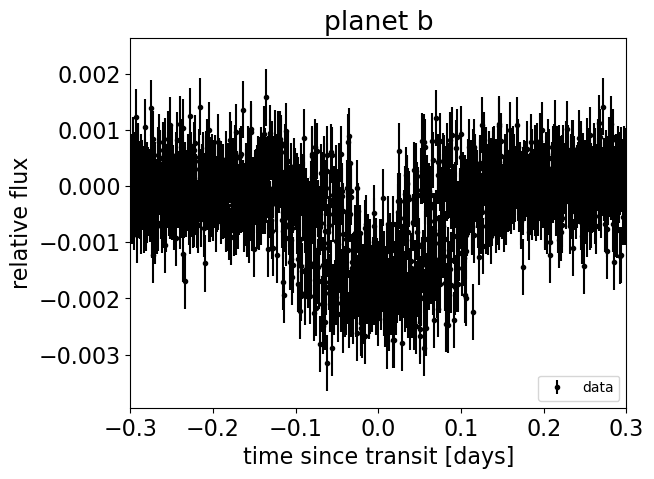

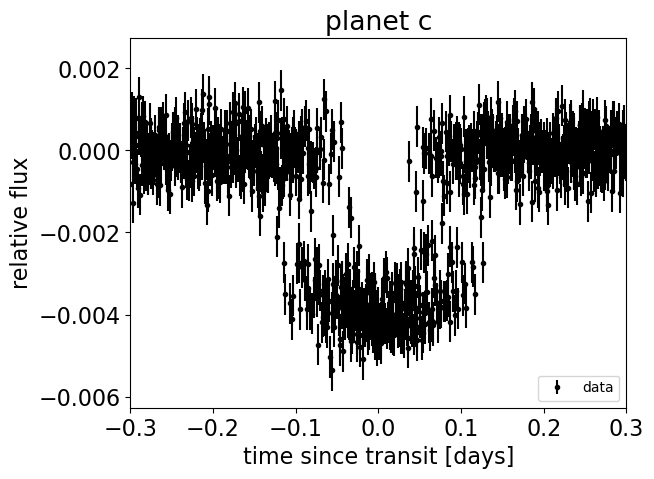

In [62]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = map_soln["period"][n]
    t0 = map_soln["t0"][n]

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = map_soln["light_curves"][:, (n + 1) % 2]

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

Instead, we can correct for the transit times by subtracting these estimates and plot that instead:

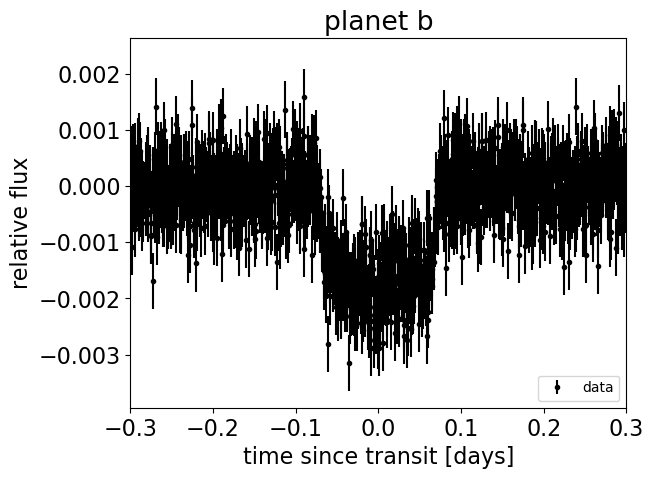

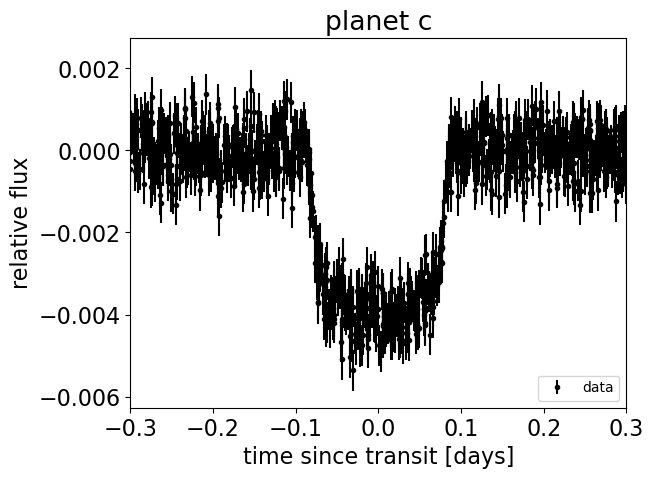

In [63]:
with model:
    t_warp = pmx.eval_in_model(orbit._warp_times(t), map_soln)

for n, letter in enumerate("bc"):
    plt.figure()

    p = map_soln["period"][n]
    other = map_soln["light_curves"][:, (n + 1) % 2]

    # NOTE: 't0' has already been subtracted!
    x_fold = (t_warp[:, n] + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

That looks better!

## Sampling

Now let's run some MCMC as usual:

In [64]:
np.random.seed(230948)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tts_1, tts_0, b, logr, u, mean]
INFO:pymc3:NUTS: [tts_1, tts_0, b, logr, u, mean]


/Users/ssagear/opt/anaconda3/envs/exoplanet/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ssagear/opt/anaconda3/envs/exoplanet/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 182 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 182 seconds.
The acceptance probability does not match the target. It is 0.9999974860971546, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9999954924026163, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not conv

Then check the convergence diagnostics:

In [69]:
import arviz as az
az.summary(trace, var_names=["mean", "u", "logr", "b", "tts_0", "tts_1"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,0.000,0.000,-0.000,0.000,0.000,0.000,3.0,15.0,1.89
u[0],0.339,0.000,0.338,0.339,0.000,0.000,3.0,17.0,2.04
u[1],0.125,0.001,0.125,0.126,0.000,0.000,3.0,12.0,2.21
logr[0],-3.218,0.001,-3.219,-3.217,0.001,0.001,3.0,12.0,2.20
logr[1],-2.810,0.001,-2.811,-2.808,0.001,0.001,3.0,52.0,1.83
b[0],0.417,0.000,0.417,0.417,0.000,0.000,3.0,20.0,2.00
b[1],0.342,0.001,0.341,0.343,0.001,0.001,3.0,55.0,1.86
tts_0[0],6.960,0.000,6.960,6.960,0.000,0.000,3.0,11.0,2.10
tts_0[1],15.109,0.000,15.109,15.110,0.000,0.000,3.0,70.0,1.83
tts_0[2],23.381,0.001,23.380,23.382,0.000,0.000,3.0,11.0,2.08


And plot the corner plot of the physical parameters:

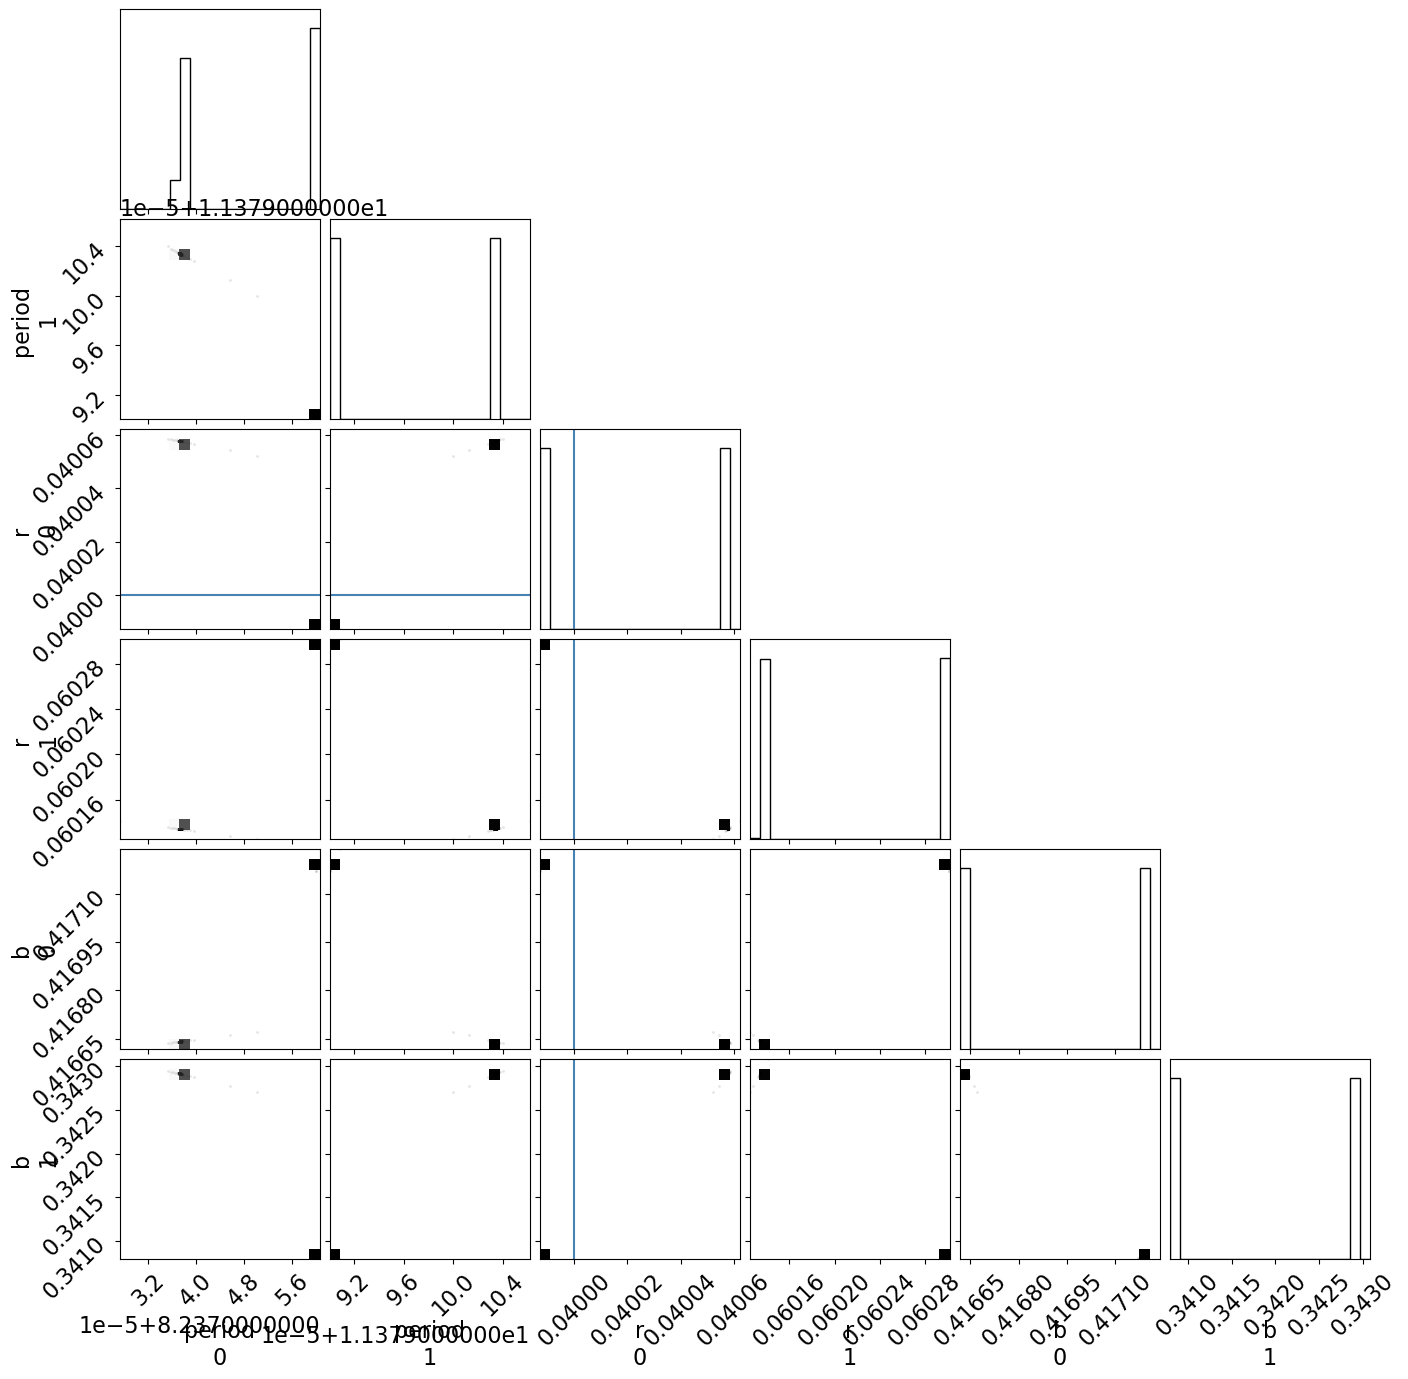

In [70]:
import corner

names = ["period", "r", "b"]

with model:
    truths = dict(zip(names, pmx.eval_in_model([orbit.period, r, b])))

_ = corner.corner(
    trace,
    truths=truths,
    var_names=names,
)

We could also plot corner plots of the transit times, but they're not terribly enlightening in this case so let's skip it.

Finally, let's plot the posterior estimates of the the transit times in an O-C diagram:

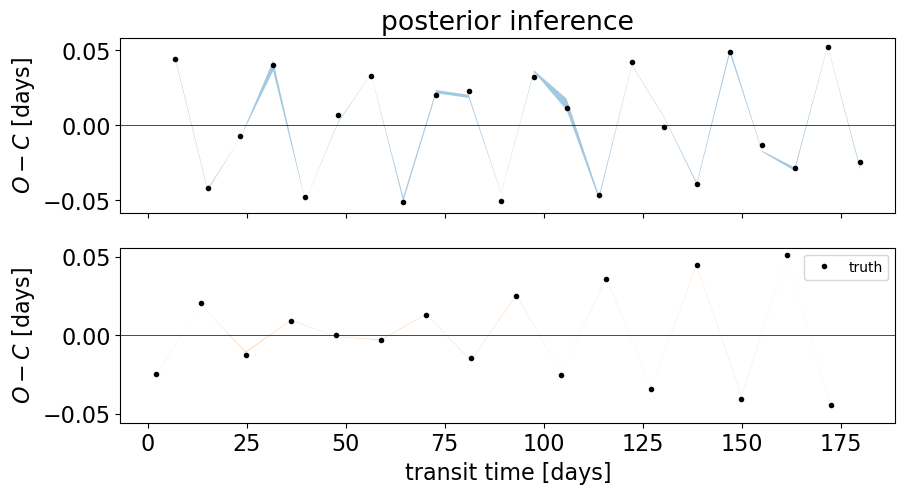

In [71]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

q = np.percentile(flat_samps["ttvs_0"], [16, 50, 84], axis=-1)
ax1.fill_between(
    np.mean(flat_samps["tts_0"], axis=-1),
    q[0],
    q[2],
    color="C0",
    alpha=0.4,
    edgecolor="none",
)
ref = np.polyval(
    np.polyfit(true_transit_times[0], true_ttvs[0], 1), true_transit_times[0]
)
ax1.plot(true_transit_times[0], true_ttvs[0] - ref, ".k")
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [days]")

q = np.percentile(flat_samps["ttvs_1"], [16, 50, 84], axis=-1)
ax2.fill_between(
    np.mean(flat_samps["tts_1"], axis=-1),
    q[0],
    q[2],
    color="C1",
    alpha=0.4,
    edgecolor="none",
)
ref = np.polyval(
    np.polyfit(true_transit_times[1], true_ttvs[1], 1), true_transit_times[1]
)
ax2.plot(true_transit_times[1], true_ttvs[1] - ref, ".k", label="truth")
ax2.axhline(0, color="k", lw=0.5)
ax2.set_ylim(np.max(np.abs(ax2.get_ylim())) * np.array([-1, 1]))

ax2.legend(fontsize=10)
ax2.set_ylabel("$O-C$ [days]")
ax2.set_xlabel("transit time [days]")
_ = ax1.set_title("posterior inference")

/Users/ssagear/opt/anaconda3/envs/exoplanet/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/Users/ssagear/opt/anaconda3/envs/exoplanet/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/ssagear/opt/anaconda3/envs/exoplanet/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/ssagear/opt/anaconda3/envs/exoplanet/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/Users/ssagear/opt/anaconda3/envs/exoplanet/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero 

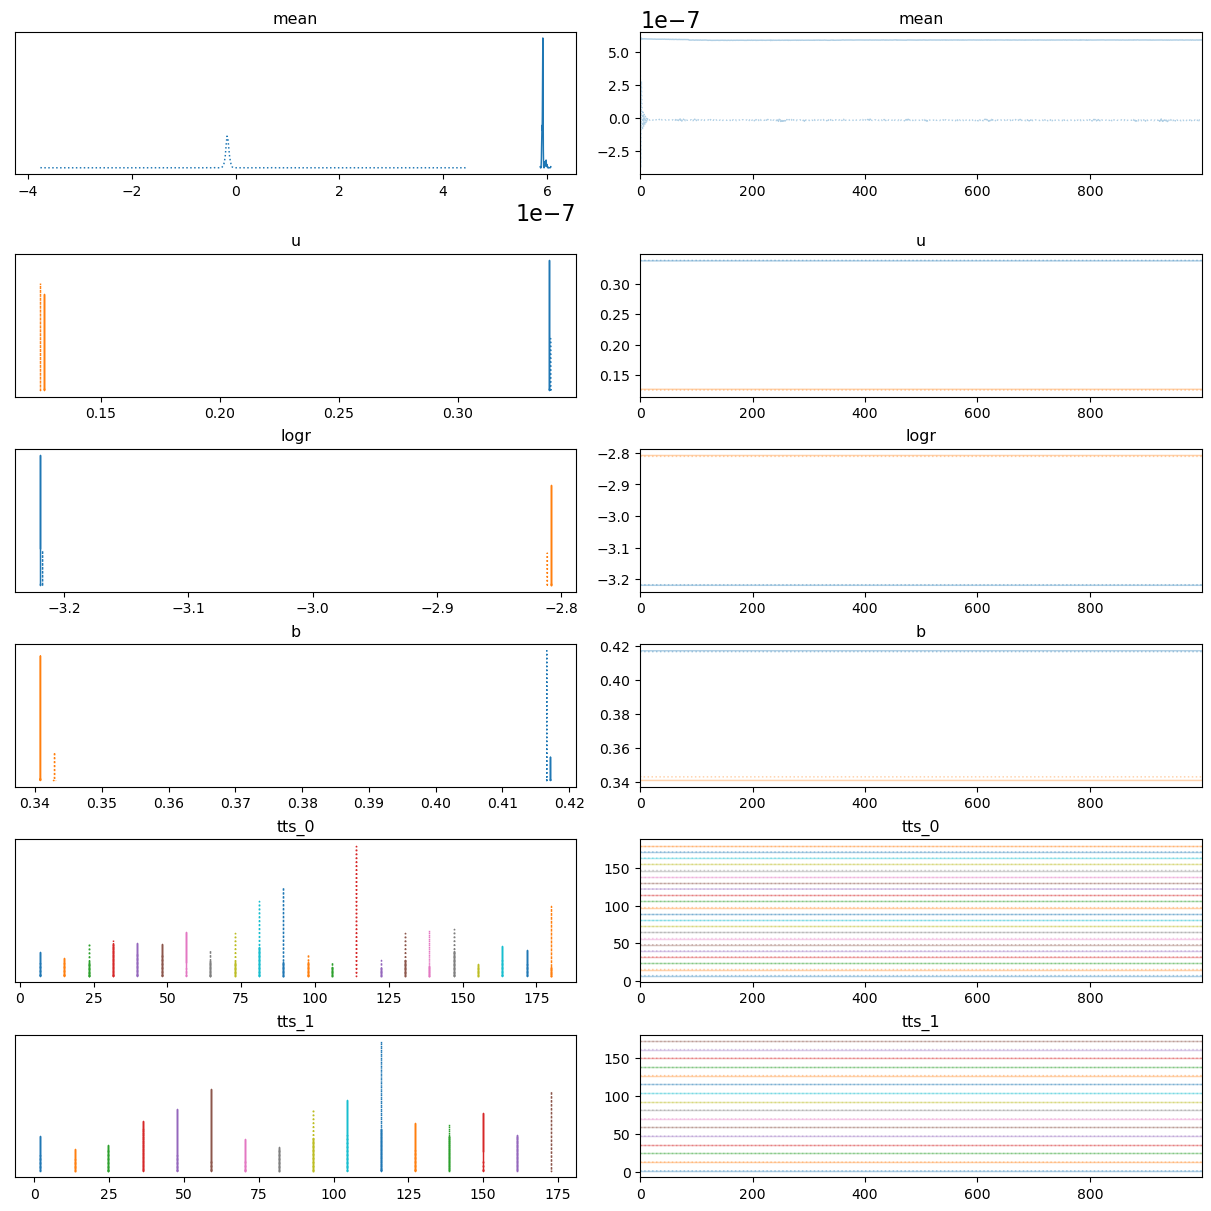

In [74]:
az.plot_trace(trace, var_names=["mean", "u", "logr", "b", "tts_0", "tts_1"]);

## Citations

As described in the [citation tutorial](https://docs.exoplanet.codes/en/stable/tutorials/citation/), we can use [citations.get_citations_for_model](https://docs.exoplanet.codes/en/stable/user/api/#exoplanet.citations.get_citations_for_model) to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [11]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet:joss,
exoplanet:zenodo} and its dependencies \citep{exoplanet:agol20,
exoplanet:arviz, exoplanet:astropy13, exoplanet:astropy18, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [12]:
print(bib.split("\n\n")[0] + "\n\n...")


@article{exoplanet:joss,
       author = {{Foreman-Mackey}, Daniel and {Luger}, Rodrigo and {Agol}, Eric
                and {Barclay}, Thomas and {Bouma}, Luke G. and {Brandt},
                Timothy D. and {Czekala}, Ian and {David}, Trevor J. and
                {Dong}, Jiayin and {Gilbert}, Emily A. and {Gordon}, Tyler A.
                and {Hedges}, Christina and {Hey}, Daniel R. and {Morris},
                Brett M. and {Price-Whelan}, Adrian M. and {Savel}, Arjun B.},
        title = "{exoplanet: Gradient-based probabilistic inference for
                  exoplanet data \& other astronomical time series}",
      journal = {arXiv e-prints},
         year = 2021,
        month = may,
          eid = {arXiv:2105.01994},
        pages = {arXiv:2105.01994},
archivePrefix = {arXiv},
       eprint = {2105.01994},
 primaryClass = {astro-ph.IM},
       adsurl = {https://ui.adsabs.harvard.edu/abs/2021arXiv210501994F},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System